# Spark SQL

Before you begin, make sure that you've installed spark of version `2.3` or higher (see `README.md`)

**Links**

* https://spark.apache.org/docs/latest/sql-getting-started.html

In [1]:
!pwd && ls -lah | grep README

/workspace/spark_sql/notebooks
-rw-rw-r-- 1 1000 1002 1.2K Feb  5 08:39 README.md


In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 2.4.4
      /_/
                        
Using Scala version 2.11.12, OpenJDK 64-Bit Server VM, 1.8.0_242
Branch 
Compiled by user  on 2019-08-27T21:31:02Z
Revision 
Url 
Type --help for more information.


## Запуск spark

In [3]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from collections import namedtuple

import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
import pyspark.sql.functions as F



spark = SparkSession \
    .builder \
    .master('local[*]') \
    .appName("spark_sql_examples") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [4]:
ls /workspace

apache_spark/        __MACOSX/                        spark_sql/
data/                on_restart.sh*                   wget-log
data_movie_lens.zip  README.md                        wget-log.1
docker/              run_jupyter.sh*                  wget-log.2
hadoop_map_reduce/   spark-2.4.4-bin-hadoop2.6.tgz    wget-log.3
intro/               spark-2.4.4-bin-hadoop2.6.tgz.1


In [5]:
DATA_PATH = '/workspace/data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

---
## DataFrame creation

DataFrame можно создать несколькими способами:

* из файла
* из существующего RDD
* из другого DataFrame'a

### From file

В случае с созданием из csv файла, может понадобится указать схему

In [6]:
from pyspark.sql.types import *


schema = StructType([
    StructField('user_id', IntegerType()),
    StructField('movie_id', IntegerType()),
    StructField('rating', FloatType()),
    StructField('timestamp', IntegerType())
])

ratings_df = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .schema(schema) \
    .options(header='true', delimiter=',') \
    .load('file:///' + RATINGS_PATH)

In [7]:
ratings_df.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- movie_id: integer (nullable = true)
 |-- rating: float (nullable = true)
 |-- timestamp: integer (nullable = true)



In [8]:
ratings_df.take(5)

[Row(user_id=1, movie_id=296, rating=5.0, timestamp=1147880044),
 Row(user_id=1, movie_id=306, rating=3.5, timestamp=1147868817),
 Row(user_id=1, movie_id=307, rating=5.0, timestamp=1147868828),
 Row(user_id=1, movie_id=665, rating=5.0, timestamp=1147878820),
 Row(user_id=1, movie_id=899, rating=3.5, timestamp=1147868510)]

### From RDD

Для того чтобы построить DataFrame из RDD нужно у RDD вызвать метод `toDF`.

*Remark:* RDD можно получить из DataFrame с помощью аттрибута `rdd`.

In [9]:
ratings = sc.textFile('file:///' + RATINGS_PATH)

In [10]:
ratings.take(5)

['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [11]:
from pyspark.sql import Row


ratings_df = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Row(user_id=int(arr[0]), 
                         movie_id=int(arr[1]), 
                         rating=float(arr[2]), 
                         timestamp=int(arr[3])))\
    .toDF()

In [12]:
ratings_df.printSchema()

root
 |-- movie_id: long (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- user_id: long (nullable = true)



---
## DataFrame API

In [13]:
import pyspark.sql.functions as F


movies_df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + MOVIES_PATH)

In [14]:
movies_df.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг.

Сравните код ниже с кодом, использующим RDD API (см. `apache_spark/notebooks/spark_examples.ipynb`):

```
ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1]) \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False) \
    .take(10)
```

In [15]:
ratings_df \
    .groupby('movie_id') \
    .agg(F.mean('rating').alias('mean_rating'), 
         F.count('rating').alias('ratings_count')) \
    .join(movies_df, ratings_df['movie_id'] == movies_df['movieId'], how='inner') \
    .sort(F.col('mean_rating').desc()) \
    .take(10)

[Row(movie_id=118995, mean_rating=5.0, ratings_count=1, movieId=118995, title='The Two Firefighters (1968)', genres='Comedy'),
 Row(movie_id=162364, mean_rating=5.0, ratings_count=1, movieId=162364, title='The Valley of Light (2007)', genres='Drama|Romance'),
 Row(movie_id=175827, mean_rating=5.0, ratings_count=1, movieId=175827, title='Cedric the Entertainer: Taking You Higher (2006)', genres='Comedy'),
 Row(movie_id=128137, mean_rating=5.0, ratings_count=1, movieId=128137, title="You're Jinxed, Friend, You've Met Sacramento (1972)", genres='(no genres listed)'),
 Row(movie_id=178247, mean_rating=5.0, ratings_count=1, movieId=178247, title='Message From Hiroshima (2015)', genres='Documentary'),
 Row(movie_id=143567, mean_rating=5.0, ratings_count=1, movieId=143567, title='Mining for Ruby (2014)', genres='(no genres listed)'),
 Row(movie_id=135232, mean_rating=5.0, ratings_count=1, movieId=135232, title='Jailbait Babysitter (1977)', genres='Comedy'),
 Row(movie_id=193795, mean_rating=5

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [16]:
%%time

movies_frequency_pdf = ratings_df \
    .groupby('movie_id') \
    .count() \
    .join(movies_df, ratings_df['movie_id'] == movies_df['movieId']) \
    .sort(F.col('count').desc()) \
    .toPandas()

CPU times: user 536 ms, sys: 59.7 ms, total: 596 ms
Wall time: 3min 15s


In [17]:
movies_frequency_pdf.head(10)

movie_id  count  movieId                                      title  \
0       356  81491      356                        Forrest Gump (1994)   
1       318  81482      318           Shawshank Redemption, The (1994)   
2       296  79672      296                        Pulp Fiction (1994)   
3       593  74127      593           Silence of the Lambs, The (1991)   
4      2571  72674     2571                         Matrix, The (1999)   
5       260  68717      260  Star Wars: Episode IV - A New Hope (1977)   
6       480  64144      480                       Jurassic Park (1993)   
7       527  60411      527                    Schindler's List (1993)   
8       110  59184      110                          Braveheart (1995)   
9      2959  58773     2959                          Fight Club (1999)   

                             genres  
0          Comedy|Drama|Romance|War  
1                       Crime|Drama  
2       Comedy|Crime|Drama|Thriller  
3             Crime|Horror|Thriller  
4            Action|Sci-Fi|Thriller  
5           Action|Adventure|Sci-Fi  
6  Action|Adventure|Sci-Fi|Thriller  
7                         Drama|War  
8                  Action|Drama|War  
9       Action|Crime|Drama|Thriller

---
## SQL

In [18]:
ratings_df.createTempView('ratings')
movies_df.createTempView('movies')

In [19]:
query = """
    SELECT movie_id, COUNT(*), first(title) as title
    FROM ratings INNER JOIN movies ON ratings.movie_id == movies.movieId
    WHERE movies.title LIKE '%(1994)%'
    GROUP BY movie_id
    ORDER BY COUNT(*) DESC
"""

movies_frequency = spark.sql(query)
movies_frequency.show()

+--------+--------+--------------------+
|movie_id|count(1)|               title|
+--------+--------+--------------------+
|     356|   81491| Forrest Gump (1994)|
|     318|   81482|Shawshank Redempt...|
|     296|   79672| Pulp Fiction (1994)|
|     364|   42745|Lion King, The (1...|
|     380|   41673|    True Lies (1994)|
|     377|   41302|        Speed (1994)|
|     344|   37453|Ace Ventura: Pet ...|
|     367|   34621|    Mask, The (1994)|
|     293|   33680|Léon: The Profess...|
|     231|   31843|Dumb & Dumber (Du...|
|     316|   30910|     Stargate (1994)|
|     349|   27766|Clear and Present...|
|     253|   27577|Interview with th...|
|     357|   26709|Four Weddings and...|
|     329|   24615|Star Trek: Genera...|
|     223|   24050|       Clerks (1994)|
|     288|   23259|Natural Born Kill...|
|     300|   18997|    Quiz Show (1994)|
|     368|   16475|     Maverick (1994)|
|     353|   16219|    Crow, The (1994)|
+--------+--------+--------------------+
only showing top

In [20]:
spark.sql(query).explain(True)

== Parsed Logical Plan ==
'Sort ['COUNT(1) DESC NULLS LAST], true
+- 'Aggregate ['movie_id], ['movie_id, unresolvedalias('COUNT(1), None), first('title, false) AS title#131]
   +- 'Filter 'movies.title LIKE %(1994)%
      +- 'Join Inner, ('ratings.movie_id = 'movies.movieId)
         :- 'UnresolvedRelation `ratings`
         +- 'UnresolvedRelation `movies`

== Analyzed Logical Plan ==
movie_id: bigint, count(1): bigint, title: string
Project [movie_id#12L, count(1)#134L, title#131]
+- Sort [count(1)#134L DESC NULLS LAST], true
   +- Aggregate [movie_id#12L], [movie_id#12L, count(1) AS count(1)#134L, first(title#31, false) AS title#131]
      +- Filter title#31 LIKE %(1994)%
         +- Join Inner, (movie_id#12L = cast(movieId#30 as bigint))
            :- SubqueryAlias `ratings`
            :  +- LogicalRDD [movie_id#12L, rating#13, timestamp#14L, user_id#15L], false
            +- SubqueryAlias `movies`
               +- Relation[movieId#30,title#31,genres#32] csv

== Optimized Logica

---
## User Defined Function (UDF)


### Количество вышедших фильмов по годам

Мы знаем, что название фильма содержит информацию о дате выхода

In [21]:
import re


def get_release_year(title):
    result = re.match(r'.*(\(\d+\))', title)
    return int(result.group(1)[1:-1]) if result is not None else None


get_release_year_udf = F.udf(get_release_year, IntegerType())

In [22]:
relase_count_by_year = movies_df \
    .withColumn('year', get_release_year_udf('title')) \
    .filter(F.col('year').isNotNull()) \
    .groupby('year') \
    .count() \
    .sort(F.col('year')) \
    .toPandas()

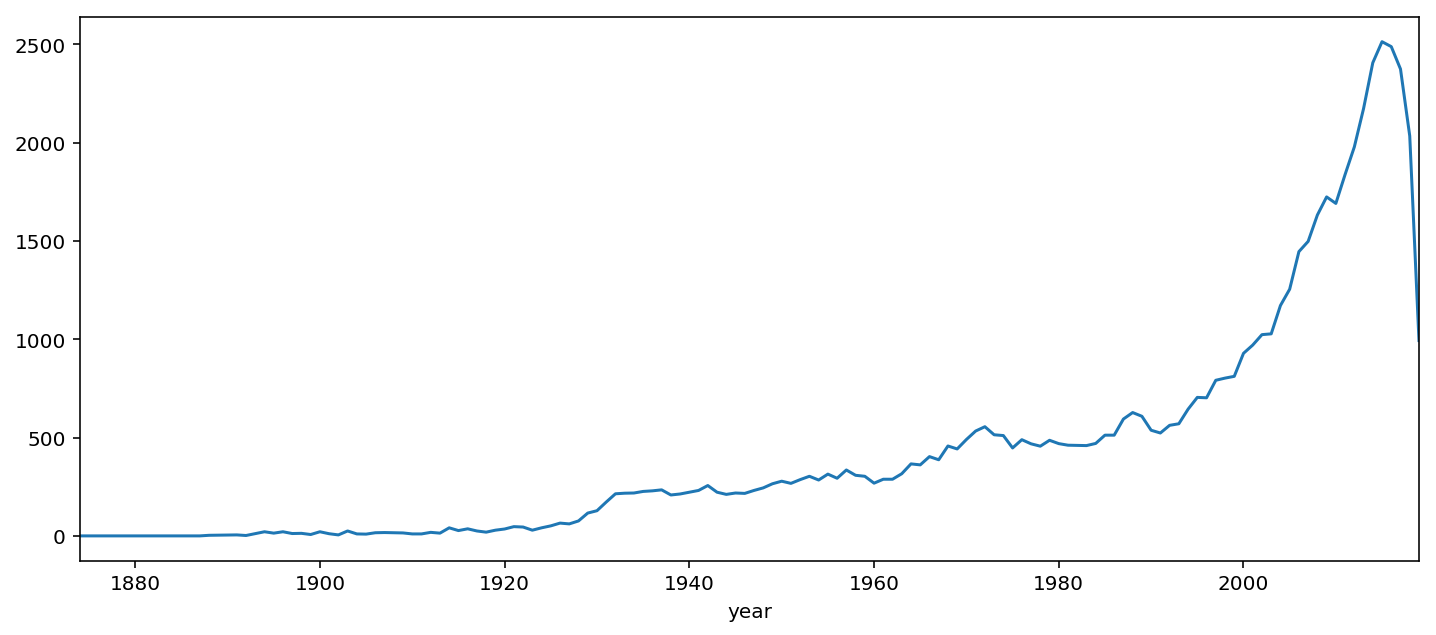

In [23]:
plt.figure(figsize=(12, 5))
relase_count_by_year.set_index('year')['count'].plot()
plt.show()

---
## Window Functions

Хотим понять, сколько времени проходит между последовательными оценками для пользователей, более формально:

Для пользователя $u$ есть последовательность $(m_1, r_1, t_1), \ldots, (m_n, r_n, t_n)$, где $t_i \leq t_{i+1}$. Рассмотрим последовательность $\Delta_i = t_{i+1} - t_i$, для $i=1,\ldots,n-1$.

Хотим построить распределение величины $\Delta_i$ используя информацию обо всех пользователях.

In [24]:
user_window = Window.orderBy('timestamp').partitionBy('user_id')

ratings_df \
    .withColumn('next_timestamp', F.lead('timestamp').over(user_window)) \
    .filter(F.col('next_timestamp').isNotNull()) \
    .take(10)

[Row(movie_id=2161, rating=3.5, timestamp=1280513623, user_id=26, next_timestamp=1280513649),
 Row(movie_id=455, rating=3.0, timestamp=1280513649, user_id=26, next_timestamp=1280513679),
 Row(movie_id=1037, rating=2.5, timestamp=1280513679, user_id=26, next_timestamp=1280513702),
 Row(movie_id=1586, rating=3.0, timestamp=1280513702, user_id=26, next_timestamp=1280513710),
 Row(movie_id=54286, rating=4.0, timestamp=1280513710, user_id=26, next_timestamp=1280513785),
 Row(movie_id=4023, rating=3.0, timestamp=1280513785, user_id=26, next_timestamp=1280513802),
 Row(movie_id=54503, rating=2.0, timestamp=1280513802, user_id=26, next_timestamp=1280513817),
 Row(movie_id=3173, rating=3.5, timestamp=1280513817, user_id=26, next_timestamp=1280513893),
 Row(movie_id=53322, rating=4.0, timestamp=1280513893, user_id=26, next_timestamp=1280513897),
 Row(movie_id=2764, rating=4.5, timestamp=1280513897, user_id=26, next_timestamp=1280513931)]

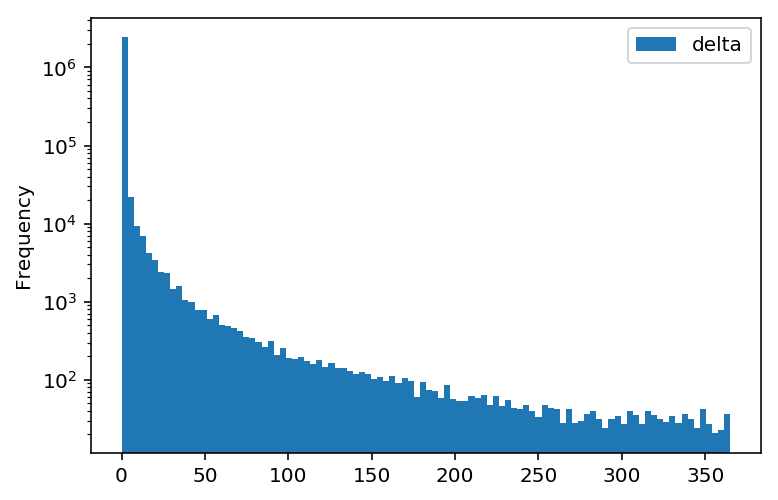

In [25]:
DAY = 24 * 60 * 60

ratings_df \
    .withColumn('next_timestamp', F.lead('timestamp').over(user_window)) \
    .filter(F.col('next_timestamp').isNotNull()) \
    .withColumn('delta', (F.col('next_timestamp') - F.col('timestamp')) / F.lit(DAY)) \
    .select('delta') \
    .filter(F.col('delta') <= 365) \
    .sample(False, 0.1) \
    .toPandas().plot.hist(bins=100, logy=True)

---
# Упражнения. Recommender System

Пусть $U$ - множество пользователей, $I$ - множество фильмов, и $R = (r_{ui})$ - матрица рейтингов. 

Через $R_u$ будем обозначать строку матрицы $R$, соотвествующую пользователю $u$.

In [26]:
ratings_df.persist()

DataFrame[movie_id: bigint, rating: double, timestamp: bigint, user_id: bigint]

In [27]:
movies_df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + MOVIES_PATH)

movies_df = movies_df.withColumnRenamed('movieId', 'movie_id')
movies_df.limit(5).toPandas()

movie_id                               title  \
0         1                    Toy Story (1995)   
1         2                      Jumanji (1995)   
2         3             Grumpier Old Men (1995)   
3         4            Waiting to Exhale (1995)   
4         5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [28]:
%%time

users = ratings_df \
  .select('user_id') \
  .distinct()

users_rand_10k = users \
  .withColumn('rand', F.rand(seed=42)) \
  .sort('rand') \
  .select('user_id') \
  .limit(10000) \
  .sort('user_id')

users_rand_10k.persist()
users_rand_10k.limit(5).toPandas().head(5)

CPU times: user 55.3 ms, sys: 11.3 ms, total: 66.6 ms
Wall time: 3min 24s


user_id
0       30
1       37
2       41
3       67
4       76

In [29]:
%%time

ratings_df_short = ratings_df.join(users_rand_10k, 'user_id')
ratings_df_short.persist()
ratings_df_short.count()

CPU times: user 9.31 ms, sys: 219 µs, total: 9.53 ms
Wall time: 3.12 s


1566540

In [30]:
ratings_df_short.limit(5).toPandas()

user_id  movie_id  rating   timestamp
0       30       377     1.5  1488511608
1       30       410     4.5  1488511992
2       30       500     4.0  1488511221
3       30      1080     4.0  1488511559
4       30      1136     4.5  1488510932

## Most similar items

Для каждого фильма $i$ определим множество $U(i) = \{ u \in U \mid r_{ui} \neq 0 \}$ - множество пользователей, поставивших фильму $i$ оценку.

Тогда мы можем определить множество $I(i) = \left\{ i' \in I ~\Big|~ sim(i, i') = \frac{|U(i) ~\cap~ U(i')|}{|U(i) ~\cup~ U(i')|} > \delta \right\}$ - множество похожих фильмов.

Можно отсортировать элементы множества $I(i)$ по неубыванию $sim(i, i')$.

Реализуйте функцию, которая на вход получает `movie_id` и возвращает топ `N` фильмов отранжированных по $sim$.

In [31]:
%%time

def find_n_most_similar(ratings_df, movie_id, n): 
    ratings_df = ratings_df.select('movie_id', 'user_id').distinct()
    ratings_df.persist()
    
    target_users = ratings_df \
      .filter(ratings_df['movie_id'] == movie_id) \
      .select('user_id')
    target_users.persist()
    
    target_user_count = target_users.count()
    
    intersections = ratings_df \
      .join(target_users, ratings_df['user_id'] == target_users['user_id'])   \
      .groupby('movie_id') \
      .count() \
      .withColumnRenamed('count', 'intersection')
    
    movie_count = ratings_df \
      .groupby('movie_id') \
      .count()

    df = intersections \
      .join(movie_count, 'movie_id')
    
    sim = df \
      .withColumn('sim', df['intersection'] / (target_user_count + df['count'] - df['intersection'])) \
      .sort('sim', ascending=False) \
      .select('movie_id', 'sim')

    return sim.limit(n)
        
sim = find_n_most_similar(ratings_df_short, movie_id=296, n=10)
sim.toPandas()

CPU times: user 157 ms, sys: 40.6 ms, total: 197 ms
Wall time: 13.8 s


movie_id       sim
0       296  1.000000
1       593  0.563642
2       318  0.530843
3       356  0.519742
4        50  0.471383
5        47  0.464457
6       480  0.448174
7       110  0.441958
8       589  0.435131
9       527  0.430733

In [32]:
sim \
  .join(movies_df, 'movie_id') \
  .sort('sim', ascending=False) \
  .toPandas()

movie_id       sim                              title  \
0       296  1.000000                Pulp Fiction (1994)   
1       593  0.563642   Silence of the Lambs, The (1991)   
2       318  0.530843   Shawshank Redemption, The (1994)   
3       356  0.519742                Forrest Gump (1994)   
4        50  0.471383         Usual Suspects, The (1995)   
5        47  0.464457        Seven (a.k.a. Se7en) (1995)   
6       480  0.448174               Jurassic Park (1993)   
7       110  0.441958                  Braveheart (1995)   
8       589  0.435131  Terminator 2: Judgment Day (1991)   
9       527  0.430733            Schindler's List (1993)   

                             genres  
0       Comedy|Crime|Drama|Thriller  
1             Crime|Horror|Thriller  
2                       Crime|Drama  
3          Comedy|Drama|Romance|War  
4            Crime|Mystery|Thriller  
5                  Mystery|Thriller  
6  Action|Adventure|Sci-Fi|Thriller  
7                  Action|Drama|War  
8                     Action|Sci-Fi  
9                         Drama|War

Построим несколько вариантов простой Рекомендательной Системы.

*Основная цель:* порекомендовать фильм пользователю. (Для простоты опустим информацию о самих рейтингах)

## Methods

При разработке сложных методов, сначала нужно выбрать несколько простотых методов (`Baseline`), относительно которых мы будем сравнивать новый метод.

In [33]:
class Recomender:
    def recomend(self, n, users):
        pass

### POP

Будем всегда рекомендовать самые популярные фильмы (с наибольшим цислом оценок пользователей).

Не смотря на свою простоту, в ряде задач показывает себя достаточно хорошо.

In [34]:
class POP(Recomender):
    def __init__(self, train):
        train = train.select('user_id', 'movie_id').distinct()
        self.top = self.get_top(train)
        self.top.persist()
    
    def recomend(self, n, users):
        recomended = users.crossJoin(self.top.limit(n))
        recomended = recomended.withColumn('neg_count', - F.col('count'))
        
        #add ranks
        user_window = Window.partitionBy('user_id').orderBy('neg_count')
        return recomended \
          .withColumn('rank', F.rank().over(user_window)) \
          .select('user_id', 'movie_id', 'rank')
        
    @staticmethod
    def get_top(ratings_df):
        return ratings_df \
          .groupby('movie_id') \
          .count() \
          .sort('count', ascending=False)

        
first_10_users = ratings_df_short \
  .select('user_id') \
  .distinct() \
  .limit(10)

pop = POP(ratings_df_short)
pop.recomend(5, first_10_users) \
  .join(movies_df, 'movie_id') \
  .orderBy('user_id') \
  .toPandas()

movie_id  user_id  rank                             title  \
0        296     1806     3               Pulp Fiction (1994)   
1        318     1806     2  Shawshank Redemption, The (1994)   
2        356     1806     1               Forrest Gump (1994)   
3        593     1806     4  Silence of the Lambs, The (1991)   
4       2571     1806     5                Matrix, The (1999)   
5        296     9978     3               Pulp Fiction (1994)   
6        318     9978     2  Shawshank Redemption, The (1994)   
7        356     9978     1               Forrest Gump (1994)   
8        593     9978     4  Silence of the Lambs, The (1991)   
9       2571     9978     5                Matrix, The (1999)   
10       296    13518     3               Pulp Fiction (1994)   
11       318    13518     2  Shawshank Redemption, The (1994)   
12       356    13518     1               Forrest Gump (1994)   
13       593    13518     4  Silence of the Lambs, The (1991)   
14      2571    13518     5                Matrix, The (1999)   
15       296    13638     3               Pulp Fiction (1994)   
16       318    13638     2  Shawshank Redemption, The (1994)   
17       356    13638     1               Forrest Gump (1994)   
18       593    13638     4  Silence of the Lambs, The (1991)   
19      2571    13638     5                Matrix, The (1999)   
20       296    17979     3               Pulp Fiction (1994)   
21       318    17979     2  Shawshank Redemption, The (1994)   
22       356    17979     1               Forrest Gump (1994)   
23       593    17979     4  Silence of the Lambs, The (1991)   
24      2571    17979     5                Matrix, The (1999)   
25       296    21965     3               Pulp Fiction (1994)   
26       318    21965     2  Shawshank Redemption, The (1994)   
27       356    21965     1               Forrest Gump (1994)   
28       593    21965     4  Silence of the Lambs, The (1991)   
29      2571    21965     5                Matrix, The (1999)   
30       296    22129     3               Pulp Fiction (1994)   
31       318    22129     2  Shawshank Redemption, The (1994)   
32       356    22129     1               Forrest Gump (1994)   
33       593    22129     4  Silence of the Lambs, The (1991)   
34      2571    22129     5                Matrix, The (1999)   
35       296    22165     3               Pulp Fiction (1994)   
36       318    22165     2  Shawshank Redemption, The (1994)   
37       356    22165     1               Forrest Gump (1994)   
38       593    22165     4  Silence of the Lambs, The (1991)   
39      2571    22165     5                Matrix, The (1999)   
40       296    25649     3               Pulp Fiction (1994)   
41       318    25649     2  Shawshank Redemption, The (1994)   
42       356    25649     1               Forrest Gump (1994)   
43       593    25649     4  Silence of the Lambs, The (1991)   
44      2571    25649     5                Matrix, The (1999)   
45       296    37261     3               Pulp Fiction (1994)   
46       318    37261     2  Shawshank Redemption, The (1994)   
47       356    37261     1               Forrest Gump (1994)   
48       593    37261     4  Silence of the Lambs, The (1991)   
49      2571    37261     5                Matrix, The (1999)   

                         genres  
0   Comedy|Crime|Drama|Thriller  
1                   Crime|Drama  
2      Comedy|Drama|Romance|War  
3         Crime|Horror|Thriller  
4        Action|Sci-Fi|Thriller  
5   Comedy|Crime|Drama|Thriller  
6                   Crime|Drama  
7      Comedy|Drama|Romance|War  
8         Crime|Horror|Thriller  
9        Action|Sci-Fi|Thriller  
10  Comedy|Crime|Drama|Thriller  
11                  Crime|Drama  
12     Comedy|Drama|Romance|War  
13        Crime|Horror|Thriller  
14       Action|Sci-Fi|Thriller  
15  Comedy|Crime|Drama|Thriller  
16                  Crime|Drama  
17     Comedy|Drama|Romance|War  
18        Crime|Horror|Thriller  
19      

### User-based Collaborative Filtering

1. Для пользователя $u$ определим множество похожих пользователей как 

$$U(u) = \left\{ u' \in U \mid sim(u, u') > \alpha \right\},$$

где $sim(u, u')$ — одна из возможных мер близости $u'$ к $u$, например, косинусная близость между $R_{u}$ и $R_{u'}$

2. $$I(u) = \left\{ i \in I ~\Big|~ B(i) = \frac{|U(u) ~\cap~ U(i)|}{|U(u) ~\cup~ U(i)|} > 0 \right\}$$


3. Отсортировать $i \in I(u)$ по убыванию $B(i)$, взять top $N$

In [35]:
%%time

class UserBasedCollab(Recomender):
    def __init__(self, train, sim_threshold=0.3):
        self.train = train.alias('train')
        self.train.persist()
        self.top = POP.get_top(train)
        self.top.persist()
        self.rating_sums = self.get_rating_sums(train)
        self.rating_sums.persist()
        self.sim_threshold = sim_threshold
    
    def recomend(self, n, users):
        similarity = self.compute_similarity(users) \
          .filter(F.col('target_user_id') != F.col('train_user_id')) \
          .filter(F.col('sim') > self.sim_threshold)
        similarity.persist()
        
        similar_count = similarity \
          .groupby('target_user_id') \
          .agg(F.count('target_user_id').alias('similar_user_count'))
        
        train = self.train.withColumnRenamed('user_id', 'train_user_id')
        
        intersection = similarity \
          .join(train, 'train_user_id') \
          .groupby(['target_user_id', 'movie_id']) \
          .count() \
          .withColumnRenamed('count', 'intersection')
        intersection.persist()
        
        user_window = Window.partitionBy('target_user_id').orderBy('neg_b')
        bs = intersection \
          .join(similar_count, 'target_user_id') \
          .join(self.top, 'movie_id') \
          .withColumn('b', F.col('intersection') / 
                          (F.col('count') + F.col('similar_user_count') - F.col('intersection'))) \
          .withColumn('neg_b', - F.col('b')) \
          .withColumn('rank', F.rank().over(user_window)) \
          .withColumnRenamed('target_user_id', 'user_id') \
          .filter(F.col('rank') <= n) \
          .select('user_id', 'movie_id', 'rank')
          
        return bs
    
    def compute_similarity(self, users):
        target_users = users.join(self.train, 'user_id').alias('target')
        train = self.train.withColumnRenamed('user_id', 'train_user_id')
        
        dot_products = train \
          .withColumnRenamed('user_id', 'train_user_id') \
          .join(target_users.withColumnRenamed('user_id', 'target_user_id'), 'movie_id') \
          .withColumn('rating_product', self.train['rating'] * target_users['rating']) \
          .select('target_user_id', 'train_user_id', 'rating_product') \
          .groupby(['target_user_id', 'train_user_id']) \
          .agg(F.sum('rating_product').alias('dot_product'))
          
        target_sums = self.rating_sums.withColumnRenamed('user_id', 'target_user_id').alias('train')
        train_sums  = self.rating_sums.withColumnRenamed('user_id', 'train_user_id').alias('target')
        
        similarity = dot_products \
          .join(target_sums, 'target_user_id') \
          .join(train_sums , 'train_user_id') \
          .withColumn('sim', F.col('dot_product') /
                            (F.sqrt(F.col('target.rating_square_sum') * F.col('train.rating_square_sum')))) \
          .select('target_user_id', 'train_user_id', 'sim')
        return similarity
        
    @staticmethod
    def get_rating_sums(ratings_df):
        return ratings_df \
            .withColumn('square_rating', F.col('rating') ** 2) \
            .groupby('user_id') \
            .agg(F.sum('square_rating').alias('rating_square_sum'))

recomender = UserBasedCollab(ratings_df_short)
recomender.recomend(1, users_rand_10k.limit(400)) \
  .limit(50) \
  .join(movies_df, 'movie_id') \
  .orderBy('user_id') \
  .toPandas()

CPU times: user 411 ms, sys: 139 ms, total: 550 ms
Wall time: 1min 11s


movie_id  user_id  rank  \
0     193069      110     1   
1     194682      110     1   
2       8360      184     1   
3       6377      296     1   
4        538      414     1   
5       3767      487     1   
6        509      530     1   
7     128360      541     1   
8      91529      650     1   
9       2406      828     1   
10      1377      939     1   
11      2554     1025     1   
12      2714     1483     1   
13     27523     1632     1   
14      2628     1806     1   
15     48516     1887     1   
16      4499     1905     1   
17      2797     2098     1   
18       349     2149     1   
19     98809     2158     1   
20     90359     2184     1   
21      5060     2227     1   
22     91529     2282     1   
23     69844     2314     1   
24    142420     2497     1   
25    184165     2710     1   
26     68157     2828     1   
27       316     2900     1   
28     69746     2966     1   
29     49530     3092     1   
30     97757     3752     1   
31      6114     4028     1   
32     69746     4116     1   
33     70286     4159     1   
34     87222     4354     1   
35      2985     4377     1   
36    103827     4462     1   
37       349     4608     1   
38     91529     4639     1   
39    109487     4905     1   
40      1527     5059     1   
41      1377     5126     1   
42    106782     5180     1   
43      3629     5572     1   
44      8645     5618     1   
45     87527     6022     1   
46     33660     6264     1   
47      1208     6313     1   
48      5816     6830     1   
49    128679     6856     1   

                                                title  \
0                                Close Enemies (2018)   
1                             Uma Vida Sublime (2018)   
2                                      Shrek 2 (2004)   
3                                 Finding Nemo (2003)   
4                    Six Degrees of Separation (1993)   
5           Missing in Action 2: The Beginning (1985)   
6                                   Piano, The (1993)   
7                            The Hateful Eight (2015)   
8                       Dark Knight Rises, The (2012)   
9                          Romancing the Stone (1984)   
10                              Batman Returns (1992)   
11                      Children of the Damned (1963)   
12                                   Wood, The (1999)   
13        My Sassy Girl (Yeopgijeogin geunyeo) (2001)   
14   Star Wars: Episode I - The Phantom Menace (1999)   
15                               Departed, The (2006)   
16                     Dirty Rotten Scoundrels (1988)   
17                                         Big (1988)   
18                    Clear and Present Danger (1994)   
19          Hobbit: An Unexpected Journey, The (2012)   
20  Männerherzen... und die ganz ganz große Liebe ...   
21                       M*A*S*H (a.k.a. MASH) (1970)   
22                      Dark Knight Rises, The (2012)   
23      Harry Potter and the Half-Blood Prince (2009)   
24                                   High Rise (2015)   
25                                   Padmaavat (2018)   
26                        Inglourious Basterds (2009)   
27                                    Stargate (1994)   
28      Watchmen: Tales of the Black Freighter (2009)   
29                               Blood Diamond (2006)   
30            'Hellboy': The Seeds of Creation (2004)   
31                          Permanent Vacation (1982)   
32      Watchmen: Tales of the Black Freighter (2009)   
33                                  District 9 (2009)   
34                             Kung Fu Panda 2 (2011)   
35                                     RoboCop (1987)   
36  To Get to Heaven First You Have to Die (Bihish...   
37                    Clear and Present Danger (1994)   
38                      Dark Knight Rises, The (2012)   
39                                Interstellar (2014)   
40                          Fifth Element, The (1997)   
41                          

### Item-kNN

1. Для пользователя $u$ мы знаем $R(u) = \{ i \in I \mid r_{ui} \neq 0 \} $


2. Для каждого $i \in R(u)$ построим $I(i)$ - множество похожих фильмов


3. Отсортируем элементы множества $ \bigcup_{i \in R(u)} I(i) $, возьмем top $N$

In [36]:
ratings_df_short.select('movie_id').distinct().count()

26780

In [49]:
%%time

class ItemKnn(Recomender):
    def __init__(self, train, sim_threshold=0.4, movie_limit=500):
        self.movie_count = POP.get_top(train).limit(movie_limit)
        train = train.select('user_id', 'movie_id').distinct()
        
        movies = self.movie_count.select('movie_id')
        train = train.join(movies, 'movie_id')
        
        self.train = train
        self.train.persist()
        self.sim_threshold = sim_threshold
        
        self.similar_movies = self.find_similar_movies(movies)
        self.similar_movies.persist()
        
    def recomend(self, n, users):
        # what we want (target_user, movie_id, similar_movie_id)
        # what we have (user, movie_id)
        
        similar_movies = self.similar_movies.withColumnRenamed('train_movie_id', 'movie_id')
        
        raw_recomendations = self.train \
          .withColumnRenamed('movie_id', 'target_movie_id') \
          .join(users, 'user_id') \
          .join(similar_movies, 'target_movie_id') \
          .select('user_id', 'movie_id') \
          .distinct()
        
        user_window = Window.partitionBy('user_id').orderBy('neg_count')
        return raw_recomendations \
                 .join(self.movie_count, 'movie_id') \
                 .withColumn('neg_count', - F.col('count')) \
                 .withColumn('rank', F.rank().over(user_window)) \
                 .filter(F.col('rank') <= n) \
                 .select('user_id', 'movie_id', 'rank')
        
    def find_similar_movies(self, target_movies):
        train = self.train.withColumnRenamed('movie_id', 'train_movie_id')
        target = self.train.join(target_movies, 'movie_id').withColumnRenamed('movie_id', 'target_movie_id')
        
        intersection = train \
          .join(target, 'user_id') \
          .groupby(['target_movie_id', 'train_movie_id']) \
          .agg(F.count('user_id').alias('intersection'))
        
        train_movie_count  = self.movie_count.withColumnRenamed('movie_id', 'train_movie_id').alias('train')
        target_movie_count = self.movie_count.withColumnRenamed('movie_id', 'target_movie_id').alias('target')
        
        similarity = intersection \
          .join(target_movie_count, 'target_movie_id') \
          .join(train_movie_count, 'train_movie_id') \
          .withColumn('sim', F.col('intersection') /  \
                            (F.col('train.count') + F.col('target.count') - F.col('intersection'))) \
          .select('target_movie_id', 'train_movie_id', 'sim') \
          .filter(F.col('sim') > self.sim_threshold) \
          .filter(F.col('target_movie_id') != F.col('train_movie_id'))
        return similarity.orderBy('target_movie_id')
        
recomender = ItemKnn(ratings_df_short)
recomender.recomend(10, users_rand_10k.limit(10)) \
  .limit(50) \
  .toPandas()

CPU times: user 247 ms, sys: 110 ms, total: 357 ms
Wall time: 38 s


user_id  movie_id  rank
0       110       356     1
1       110       318     2
2       110       296     3
3       110       593     4
4       110      2571     5
5       110       260     6
6       110       480     7
7       110       527     8
8       110       110     9
9       110      2959    10
10      124       356     1
11      124       318     2
12      124       296     3
13      124       593     4
14      124      2571     5
15      124       480     6
16      124       527     7
17      124       110     8
18      124      2959     9
19      124      1196    10
20       41       356     1
21       41       318     2
22       41       296     3
23       41       593     4
24       41      2571     5
25       41       260     6
26       41       480     7
27       41       110     8
28       41      2959     9
29       41         1    10
30       67       356     1
31       67       318     2
32       67       296     3
33       67       593     4
34       67      2571     5
35       67       260     6
36       67       480     7
37       67       110     8
38       67      2959     9
39       67         1    10
40       37       356     1
41       37       318     2
42       37       296     3
43       37       593     4
44       37      2571     5
45       37       480     6
46       37       527     7
47       37       110     8
48       37      2959     9
49       37       589    10

## Evaluation Protocol

Теперь опишем, как будем оценивать качество рассматриваемых методов.

### Data Splits

Так как в данных `ratings` есть поле `timestamp`, то для каждого пользователя отсортируем его рейтинги по времени и первые $80\%$ рейтингов отнесем в `Train`, еще $10\%$ в `Validation`, и остальное в `Test`.


In [38]:
from pyspark.sql.window import Window
import pyspark.sql.functions as F

def train_validate_test_split(ratings_df, train_size, validate_size):
    user_window = Window.orderBy('timestamp').partitionBy('user_id')

    ratings_with_ranks = ratings_df_short \
      .withColumn('percent_rank', F.percent_rank().over(user_window))

    train = ratings_with_ranks \
      .filter(ratings_with_ranks['percent_rank'] < train_size) \
      .drop('percent_rank')

    validate = ratings_with_ranks \
      .filter((train_size <= ratings_with_ranks['percent_rank'])  \
                          & (ratings_with_ranks['percent_rank'] < train_size + validate_size)) \
      .drop('percent_rank')

    test = ratings_with_ranks \
      .filter(train_size + validate_size <= ratings_with_ranks['percent_rank']) \
      .drop('percent_rank')
    
    return train, validate, test

train, validate, test = train_validate_test_split(ratings_df_short, 0.8, 0.1)

### Metrics

В `Test` для каждого пользователя есть `user_id, R_u`, где $R_u$ - множество фильмов, которым он поставил оценку. Для того чтобы оценить качество рассматриваемых методов будем для пользователя строить список из $N$ рекомендаций $\hat{R}_{1\colon N}$ и считать метрики.

* $$ Precision@N = \frac{|R_u \cap \hat{R}_{1\colon N} |}{N} $$
* $$ Recall@N = \frac{|R_u \cap \hat{R}_{1\colon N} |}{|R_u|} $$
* $Map@N$

где $N \in \{1,5,10\}$

https://spark.apache.org/docs/latest/mllib-evaluation-metrics.html#ranking-systems

## Experimental Results

Посмотрим на результаты

*Remark* скорее всего посчитать метрики для всех пользователей будет довольно долго - можно ограничится, например, случайными 10к пользователями

In [39]:
#       recomended: Dataframe[(user_id, movie_id, rank)]
#       inference:  Dataframe[(user_id, movie_id)]
def precision_recall(recomended, inference):
    intersection = recomended \
      .withColumn('reciprocal_rank', 1. / F.col('rank')) \
      .join(inference, ['movie_id', 'user_id']) \
      .groupby('user_id') \
      .agg(F.count('user_id').alias('intersection'),
           F.sum('reciprocal_rank').alias('precision_sum'))
    intersection.persist()
    
    precisions = recomended \
      .groupby('user_id') \
      .count() \
      .join(intersection, 'user_id', how='left') \
      .na.fill(0) \
      .withColumn('precision', F.col('intersection') / F.col('count')) \
      .withColumn('avg_precision', F.col('precision_sum') / F.col('count'))
    
    precision = precisions.agg(F.avg(F.col("precision"))).collect()[0][0]
    mean_avg_precision = precisions.agg(F.avg(F.col("avg_precision"))).collect()[0][0]
    
    recalls = inference \
      .groupby('user_id') \
      .count() \
      .join(intersection, 'user_id', how='left') \
      .na.fill(0) \
      .withColumn('recall', F.col('intersection') / F.col('count'))
    
    recall = recalls.agg(F.avg(F.col("recall"))).collect()[0][0]
    MetricValues = namedtuple('MetricValues', ['precision', 'recall', 'mean_avg_precision'])
    return MetricValues(precision, recall, mean_avg_precision)

### Evaluate Pop

In [40]:
train, validate, test = train_validate_test_split(ratings_df_short, 0.8, 0.1)

recomended = POP(train).recomend(1, users_rand_10k)    
precision_recall(recomended, test)

MetricValues(precision=0.0191, recall=0.002753858298206901, mean_avg_precision=0.0191)

In [41]:
recomended = POP(train).recomend(5, users_rand_10k)    
precision_recall(recomended, test)

MetricValues(precision=0.0205, recall=0.014383318953265275, mean_avg_precision=0.009320666666666668)

In [42]:
recomended = POP(train).recomend(10, users_rand_10k)    
precision_recall(recomended, test)

MetricValues(precision=0.019049999999999987, recall=0.02640670562053017, mean_avg_precision=0.005792801587301586)

In [43]:
recomended = POP(train).recomend(10, users_rand_10k)    
precision_recall(recomended, validate) # validate

MetricValues(precision=0.02039000000000001, recall=0.03161380504745408, mean_avg_precision=0.005925460317460319)

### Evaluate UserBasedCollab

In [44]:
cur_users = users_rand_10k.limit(400)
train, validate, test = train_validate_test_split(ratings_df_short, 0.8, 0.1)

recomended = UserBasedCollab(train).recomend(1, cur_users)    
precision_recall(recomended, test.join(cur_users, 'user_id'))

MetricValues(precision=0.008928571428571428, recall=0.0014540115563133466, mean_avg_precision=0.008928571428571428)

In [45]:
recomended = UserBasedCollab(train).recomend(5, cur_users)    
precision_recall(recomended, test.join(cur_users, 'user_id'))

MetricValues(precision=0.008333333333333333, recall=0.005979309807708848, mean_avg_precision=0.0035912698412698418)

In [46]:
recomended = UserBasedCollab(train).recomend(10, cur_users)    
precision_recall(recomended, test.join(cur_users, 'user_id'))

MetricValues(precision=0.010119047619047625, recall=0.01341408885892843, mean_avg_precision=0.002552437641723356)

In [47]:
recomended = UserBasedCollab(train).recomend(10, cur_users)    
precision_recall(recomended, validate.join(cur_users, 'user_id')) # validate

MetricValues(precision=0.00823759573759574, recall=0.009112456159550955, mean_avg_precision=0.002081696412053555)

### Evaluate Item-kNN

In [50]:
train, validate, test = train_validate_test_split(ratings_df_short, 0.8, 0.1)

recomender = ItemKnn(train)
recomended = recomender.recomend(1, users_rand_10k)    
precision_recall(recomended, test)

MetricValues(precision=0.019025953882742218, recall=0.0023780333722425574, mean_avg_precision=0.019025953882742218)

In [51]:
recomended = recomender.recomend(5, users_rand_10k)    
precision_recall(recomended, test)

MetricValues(precision=0.02112328955985247, recall=0.014306859307874705, mean_avg_precision=0.009769183929043305)

In [52]:
recomended = recomender.recomend(10, users_rand_10k)    
precision_recall(recomended, test)

MetricValues(precision=0.01993470086480116, recall=0.026273681666523243, mean_avg_precision=0.006396487458289801)

In [53]:
recomended = recomender.recomend(10, users_rand_10k)    
precision_recall(recomended, validate) # validate

MetricValues(precision=0.022782562168354743, recall=0.03367073686710488, mean_avg_precision=0.006828174758837613)